# A Brief explaination of GWcosmo

GWcosmo is a package used to estimate the Hubble constant with gravitational-wave observations. GWcosmo can estimate the Hubble constant with three settings:

* With an indentified galaxy for the GW identified

* With a galaxy catalogue (we do not know the hosting galaxy)

* With an empty galaxy catalogue, just by using the masses of the GW event, see later

In this notebook we will present a tutorial on how to use GWcosmo to measure the Hubble constant from GW170817 with its associated EM counterpart.  I will show you how to handle the ingredients which are necessary for the analysis.
For an in depth description of the statistical method behind GWcosmo check this [paper](https://arxiv.org/abs/1908.06050).

## The method behind GWcosmo

We use the Bayes theorem to write down the posterior on the Hubble consant.

$p(H_0|x)=\frac{p(x|H_0)p(H_0)}{\beta(H_0)}$,

where 

$p(H_0|x_{GW},x_{EM})\propto \frac{p(H_0)}{\beta(H_0)} \int_{z,m_{1,s},m_{2,s}} p(x_{GW}|z,m_{1,s},m_{2,s},H_0) p(x_{EM}|z) p(m_{1,s},m_{2,s}) p(z) \, dz dm_{1,s} dm_{2,s}$

where 

* $p(x|z,m_{1,s},m_{2,s},H_0)$ is the GW likelihood expressed in terms of redshift, source-frame masses and Hubble constant
* $ p(z)$ and $p(m_{1,s},m_{2,s})$ are the redshift and masses priors that we assume in our analysis. Note that these priors should match with the population you are looking at, otherwise, due to selection bias, you will get a wrong result on $H_0$.
* $\beta(H_0)$ is a term that takes into account selection biases.

**Note** In many parts of this notebook I will use the following way of doing integrals for posteriors $p(a|x)$

$$ \int p(a|x) \pi(a) da \propto \frac{1}{N_{samp}}\sum_{i}^{N_{samp}} \pi(a_i)$$






### The selection effect

Let us start by looking at the $\beta(H_0)$ factor. This term is usually not present in classical Bayesian analysis and it represent a normalization factor with respect to a value of $H_0$.

This factor here should be included because this kind of analysis is prone to a **selection bias**, i.e. for some values of $H_0$ GW events are easier to detect. The selection effect can be calulated as

$ \beta(H_0) = \int p_{\rm det}(z,H_0) p(z) \, dz$,

in GWcosmo we provide these ingredients


In [224]:
%matplotlib inline
import gwcosmo
import numpy as np
import pkg_resources
import pickle
import os
import matplotlib.pyplot as plt
import scipy
print(scipy.__version__)
plt.rcParams['mathtext.fontset'] = 'stix'  # Options: 'stix', 'cm', 'dejavusans', etc.
plt.rcParams['mathtext.rm'] = 'Times New Roman'  # Roman font for math
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'  # Italic font for math
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'  # Bold font for math
plt.rcParams['figure.dpi'] = 300 # 200 e.g. is really fine, but slower

1.10.1


In [29]:
# Read where gwcosmo is installed and look at the pdet files available
data_path = pkg_resources.resource_filename('gwcosmo', 'data/')
print(data_path)
os.listdir(data_path)

/Library/anaconda3/envs/gdrgwcosmo/lib/python3.10/site-packages/gwcosmo-2.1.0-py3.10.egg/gwcosmo/data/


['L1_O1_strain.txt',
 'K1_O4high_strain.txt',
 'H1_O3_strain.txt',
 'O1PSD_BBH-powerlaw_alpha_2.3_Mmin_5.0_Mmax_100.0_Nsamps20000_full_waveform_snr_12.0.p',
 'K1_O4low_strain.txt',
 'PSD_L1_H1_mid.txt',
 'p_original_files',
 'O3PSD_BNS_Nsamps20000_full_waveform.p',
 'H1_O4high_strain.txt',
 'V1_O2_strain.txt',
 'V1_O5_strain.txt',
 'H1_O4low_strain.txt',
 'O2PSD_BBH-powerlaw_alpha_1.6_Mmin_5.0_Mmax_50.0_Nsamps20000_full_waveform_snr_12.0.p',
 'V1_O4low_strain.txt',
 'L1_O3_strain.txt',
 'O2PSD_BBH-powerlaw_alpha_2.3_Mmin_5.0_Mmax_100.0_Nsamps20000_full_waveform_snr_12.0.p',
 'H1_O1_strain.txt',
 'L1_O4low_strain.txt',
 'O2PSD_BNS_Nsamps20000_full_waveform_snr_12.0.p',
 'O3PSD_NSBH_Nsamps20000_full_waveform.p',
 'O3PSD_BBH-powerlaw_alpha_1.6_Mmin_5.0_Mmax_100.0_Nsamps20000_full_waveform.p',
 'K1_O5_strain.txt',
 'L1_O4high_strain.txt',
 'V1_O4high_strain.txt',
 'L1_O5_strain.txt',
 'V1_O3_strain.txt',
 'O1PSD_BBH-powerlaw_alpha_1.6_Mmin_5.0_Mmax_50.0_Nsamps20000_full_waveform_snr_12.0.p

In [30]:
# Load the detector probability class, it is precomputed from us
pdet = pickle.load(open(data_path +
                        'O2PSD_BNS_Nsamps20000_full_waveform_snr_12.0.p', 'rb'))
print(type(pdet))
pdet0 = pickle.load(open(data_path + 'O3PSD_BNS_Nsamps20000_full_waveform.p', 'rb'))

<class 'gwcosmo.likelihood.detection_probability.DetectionProbability'>


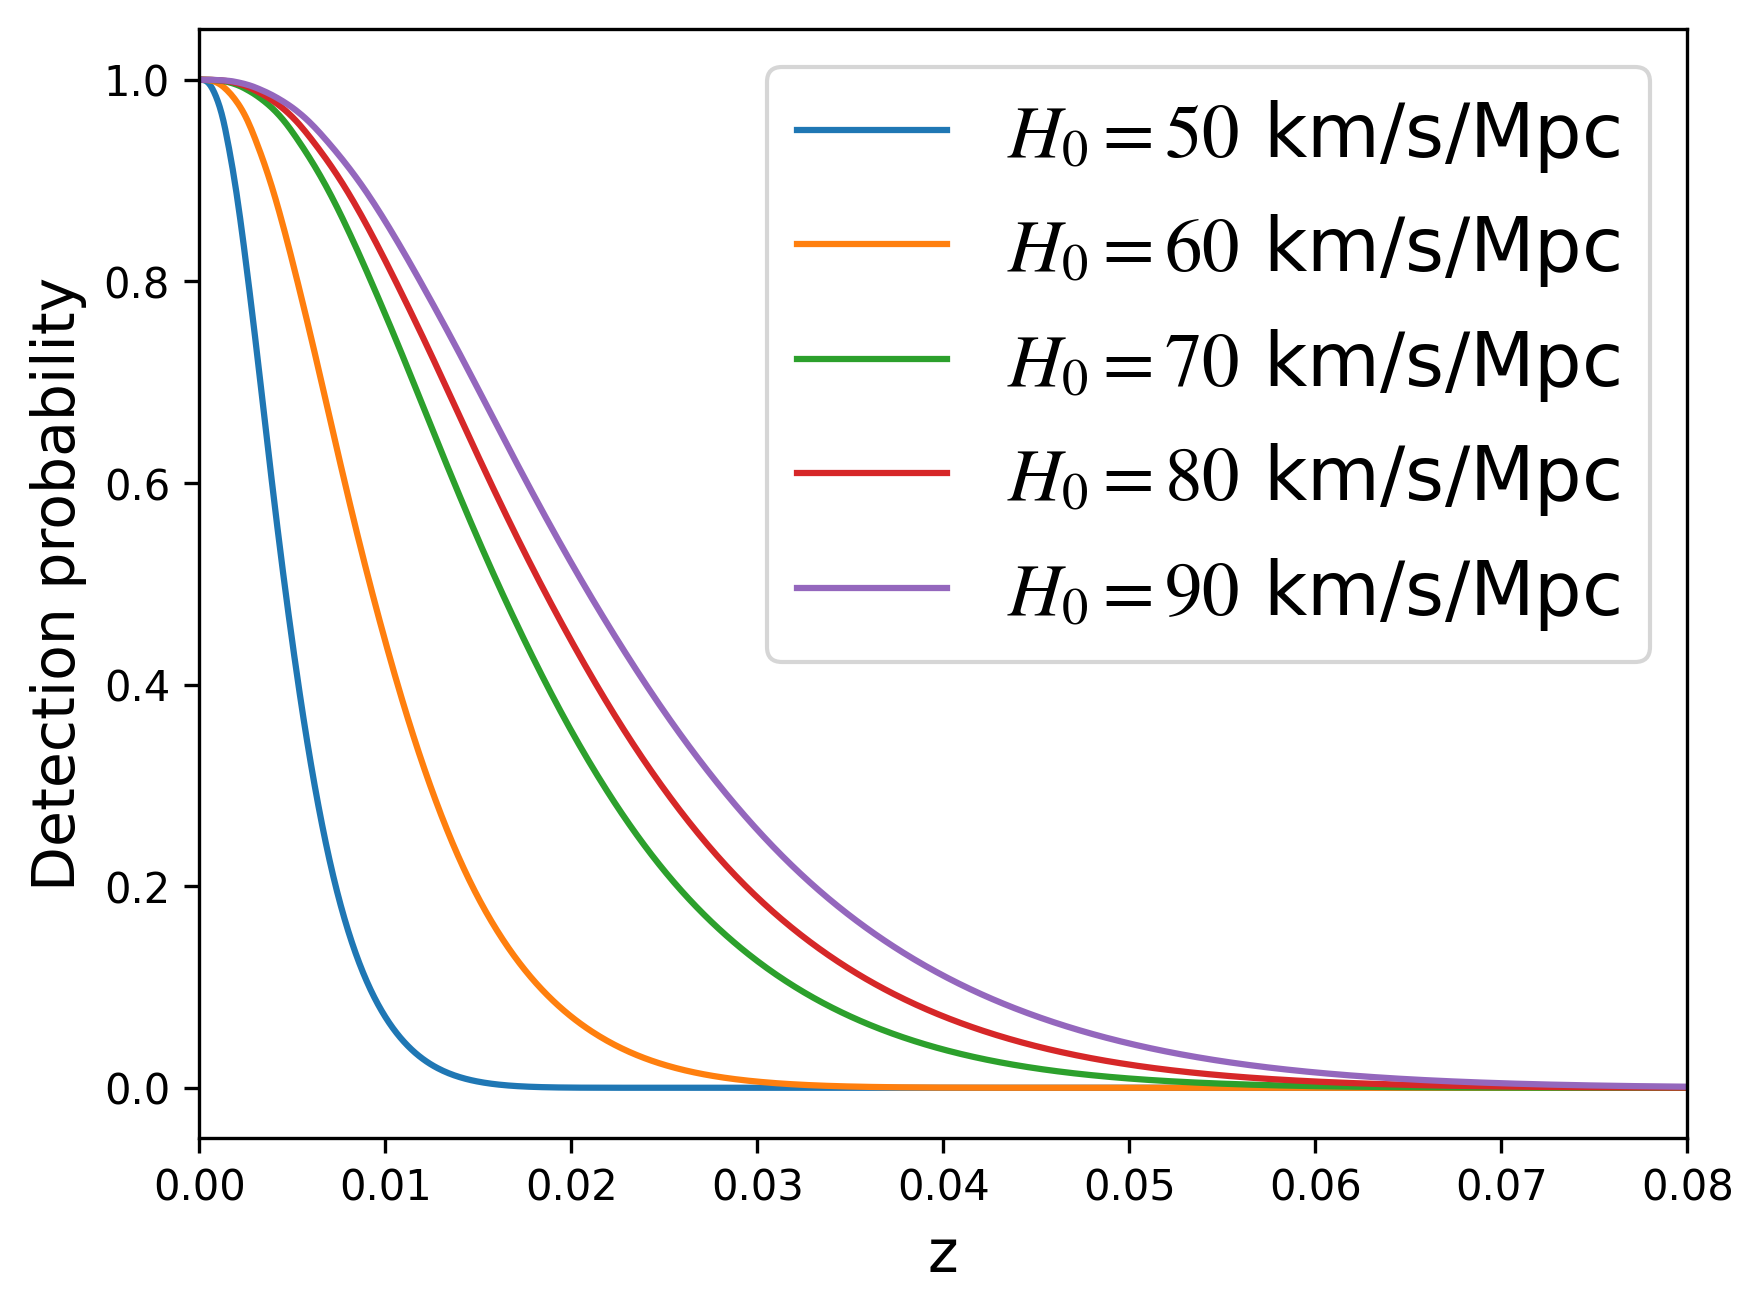

In [226]:
# Let us plot the detection probability
H0 = 70 # Hubble constant in km/Mpc/s
z_array = np.linspace(0.0, 0.1, 1000) # Redshift at which you want to evaluate your det. probability
pdet_array = pdet.pD_zH0_eval(z_array, H0) # Use the pdet method to compute pdet
pdet_array20 = pdet.pD_zH0_eval(z_array, 20) # Use the pdet method to compute pdet
pdet_array40 = pdet.pD_zH0_eval(z_array, 40) # Use the pdet method to compute pdet
pdet_array80 = pdet.pD_zH0_eval(z_array, 80) # Use the pdet method to compute pdet
pdet_array90 = pdet.pD_zH0_eval(z_array, 90) # Use the pdet method to compute pdet
plt.plot(z_array, pdet_array20, label = r'$H_0=50$ km/s/Mpc')
plt.plot(z_array, pdet_array40, label = r'$H_0=60$ km/s/Mpc')
plt.plot(z_array, pdet_array, label = r'$H_0=70$ km/s/Mpc')
plt.plot(z_array, pdet_array80, label = r'$H_0=80$ km/s/Mpc')
plt.plot(z_array, pdet_array90, label = r'$H_0=90$ km/s/Mpc')
#plt.title(fr'$H_0={H0}$')
plt.ylabel('Detection probability', fontsize=14)
plt.xlabel('z', fontsize=14)
plt.xlim(0.0, 0.08)
plt.legend(fontsize = 18)

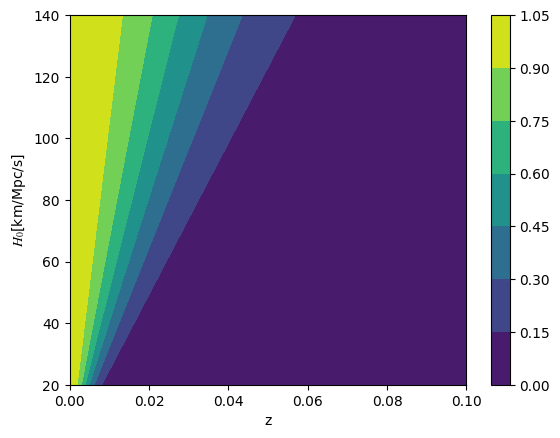

In [32]:
# Here we evaluate pdet over a grid of redshift and H0
H0_array = np.linspace(20, 140, 100)
pdet_array = pdet.pD_zH0_eval(z_array, H0_array)

zz, hh = np.meshgrid(z_array,H0_array)

plt.contourf(zz, hh, pdet_array)
plt.ylabel(r'$H_0$[km/Mpc/s]')
plt.xlabel('z')
plt.colorbar()

In [33]:
# We import the redshift prior class
from gwcosmo.utilities.standard_cosmology import redshift_prior

Text(0, 0.5, 'pdf')

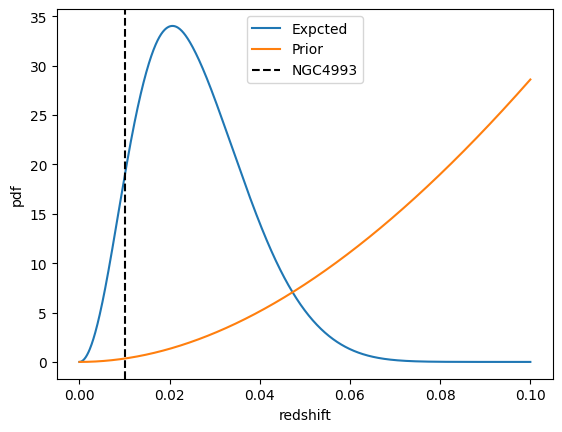

In [35]:
# Here we calculate the expcted detection redshift for BNS in a Universe with H0=70
p_z = redshift_prior()
prior_porb = p_z.p_z(z_array)
prior_porb/=np.trapz(prior_porb,z_array)

# Calculate the expected events in redshift and normalize
det_expected = prior_porb*pdet.pD_zH0_eval(z_array,70)
det_expected /=np.trapz(det_expected,z_array)

plt.plot(z_array,det_expected,label='Expcted')
plt.plot(z_array,prior_porb,label='Prior')
plt.axvline(0.01,label='NGC4993',ls='--',c='k')
plt.legend()
plt.xlabel('redshift')
plt.ylabel('pdf')

Text(0, 0.5, 'Selection bias')

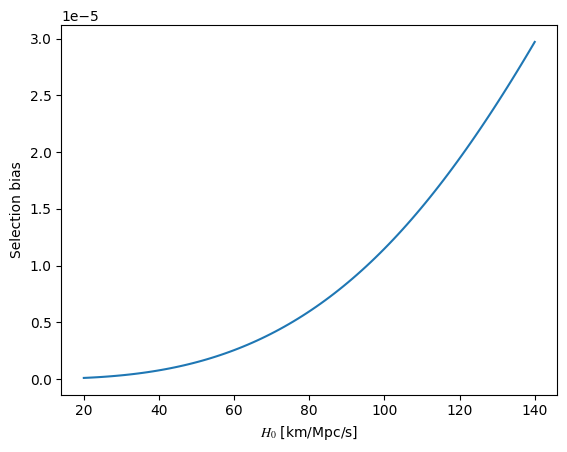

In [36]:
# This is the selection effect

beta = np.zeros_like(H0_array)

for i, H0 in enumerate(H0_array):
    beta[i]=np.trapz(pdet.pD_zH0_eval(z_array,H0)*p_z.p_z(z_array),z_array)

plt.plot(H0_array, beta)
plt.xlabel('$H_0$ [km/Mpc/s]')
plt.ylabel('Selection bias')

In [10]:
# A block to calculate a pdet class from scratch! It is slow, so I am not going to run it
asd = 'O2' # ASD of the detectors
mmin = 0.5 # Minimum mass in solar masses
mmax = 5 # Maximum mass in solar masses
mass_distribution = 'BNS' # Masses distribution, see mass_distribution class in prior module
detectors = ['H1', 'L1']
# alpha = 2 # Powerlaw slope for BBHs mass distribution
Nsamps = 5 #How many injection per H0,z bin
network_snr_threshold = 12 # SNR threshold for detection 
kind = 'full_waveform' # Kind of injections, use full waveforms with IMRPhenomPv2

H0 = np.linspace(40, 100, 100) # H0 at which you want to calculate
H0 = 70.0
pdet = gwcosmo.detection_probability.DetectionProbability(mass_distribution=mass_distribution,
asd=asd, 
full_waveform = kind,H0 = H0,network_snr_threshold = network_snr_threshold,
detectors = detectors,
Nsamps = Nsamps)


100% |########################################################################|


Powerlaw mass distribution with alpha = 0.0
Calculating lookup table for snr as a function of max frequency.
Calculating lookup table for snr as a function of max frequency.
Calculating pdet with O2 sensitivity and BNS mass distribution.


TypeError: 'float' object is not iterable

100


Text(0.5, 0, 'z')

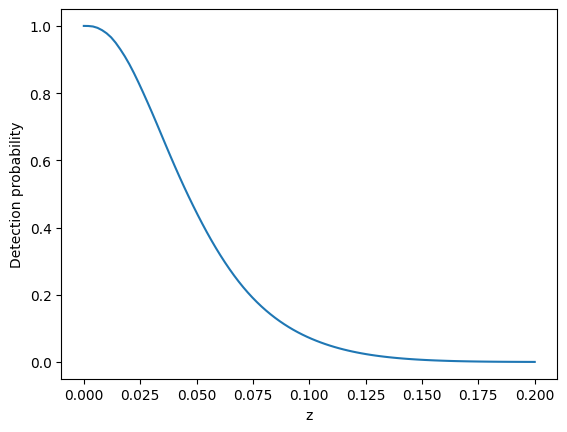

In [171]:
z_array = np.linspace(0.0, 0.2, 100) # Redshift at which you want to evaluate your det. probability
pdet_array = pdet.pD_zH0_eval(z_array,H0) # Use the pdet method to compute pdet
# print(pdet_array)
print(len(pdet_array))
plt.plot(z_array, pdet_array)
plt.ylabel('Detection probability')
plt.xlabel('z')

### The gravitational wave likelihood

The gravitavitational-wave likelihood is not something that we are provided with. The LVC provides us with a set of posterior samples on the luminosity distance of the source and their detected masses in DETECTOR FRAME. Note that $m_d = (1+z) m_s$.

In this sense we are not provided with $p(x|z,H_0,m_{1,s},m_{2,s})$. So we are going to use the Bayes theorem and write

$ p(x|z,H_0,m_{1,s},m_{2,s}) \propto \frac{p(z,m_{1,s},m_{2,s}|x,H_0)}{\pi(z,m_{1,s},m_{2,s}|H_0)} $,

where the numerator can be computed starting from the posterior samples, while the term $\pi(z,m_{1,s},m_{2,s}|H_0)$ is the prior used by the LVC to produce posterior samples. The LVC put uniform priors in detector frame masses and a squared prior on the luminosity distance, so the above Eq can be rewritten as

$ p(x|z,H_0,m_{1,s},m_{2,s}) \propto \frac{p(z,m_{1,s},m_{2,s}|x,H_0)}{|J| d^2_L(z,H0) } $,

where $|J|$ is the determinant of the Jacobian of the transformation from detector frame to source frame.


In [38]:
from gwcosmo.likelihood.posterior_samples import posterior_samples
import corner.corner

# Uncomment below to download GW170817 posterior samples

# !wget https://dcc.ligo.org/public/0157/P1800370/005/GW170817_GWTC-1.hdf5

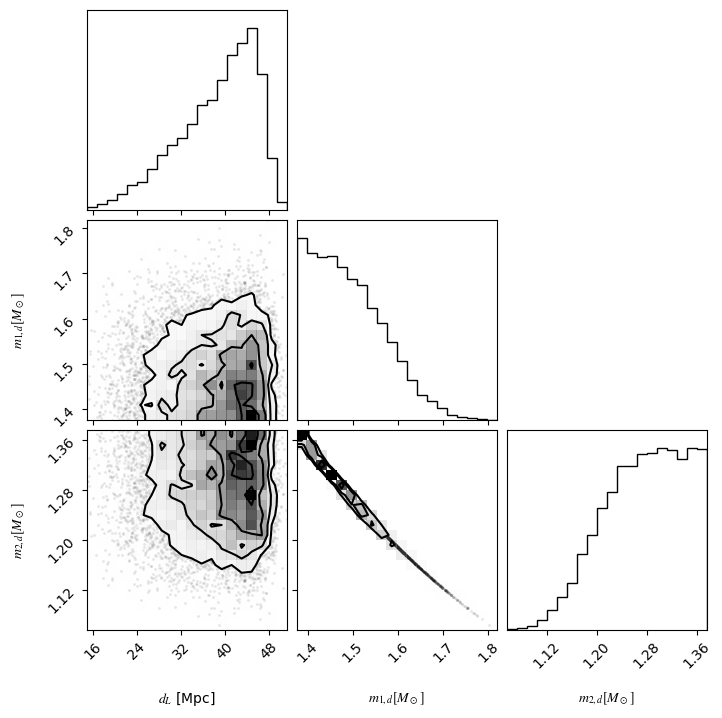

In [39]:
# Load the posterior samples. Currently we support hdf5 from GWTC-1 and h5 from GWTC-2.
GW170817 = posterior_samples('GW170817_GWTC-1.hdf5')

# Plots in detector frame
to_plot = np.column_stack([GW170817.distance, GW170817.mass_1, GW170817.mass_2])
_ = corner.corner(to_plot,labels=[r'$d_L$ [Mpc]', r'$m_{1,d} [M_\odot]$ ',r'$m_{2,d} [M_\odot]$ '])



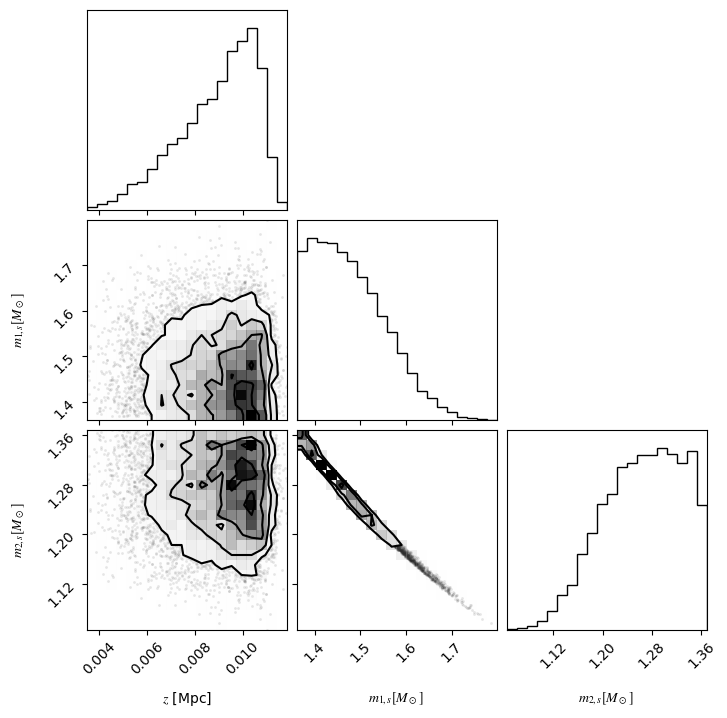

In [14]:
# Plots in source frame
redshift, mass_1_source, mass_2_source = GW170817.compute_source_frame_samples(70)
to_plot = np.column_stack([redshift,mass_1_source,mass_2_source])
_ = corner.corner(to_plot,labels=[r'$z$ [Mpc]', r'$m_{1,s} [M_\odot]$ ',r'$m_{2,s} [M_\odot]$ '])


(<scipy.stats._kde.gaussian_kde object at 0x30f9f4a90>, 0.00035642973837701303)
1.0210862413244923


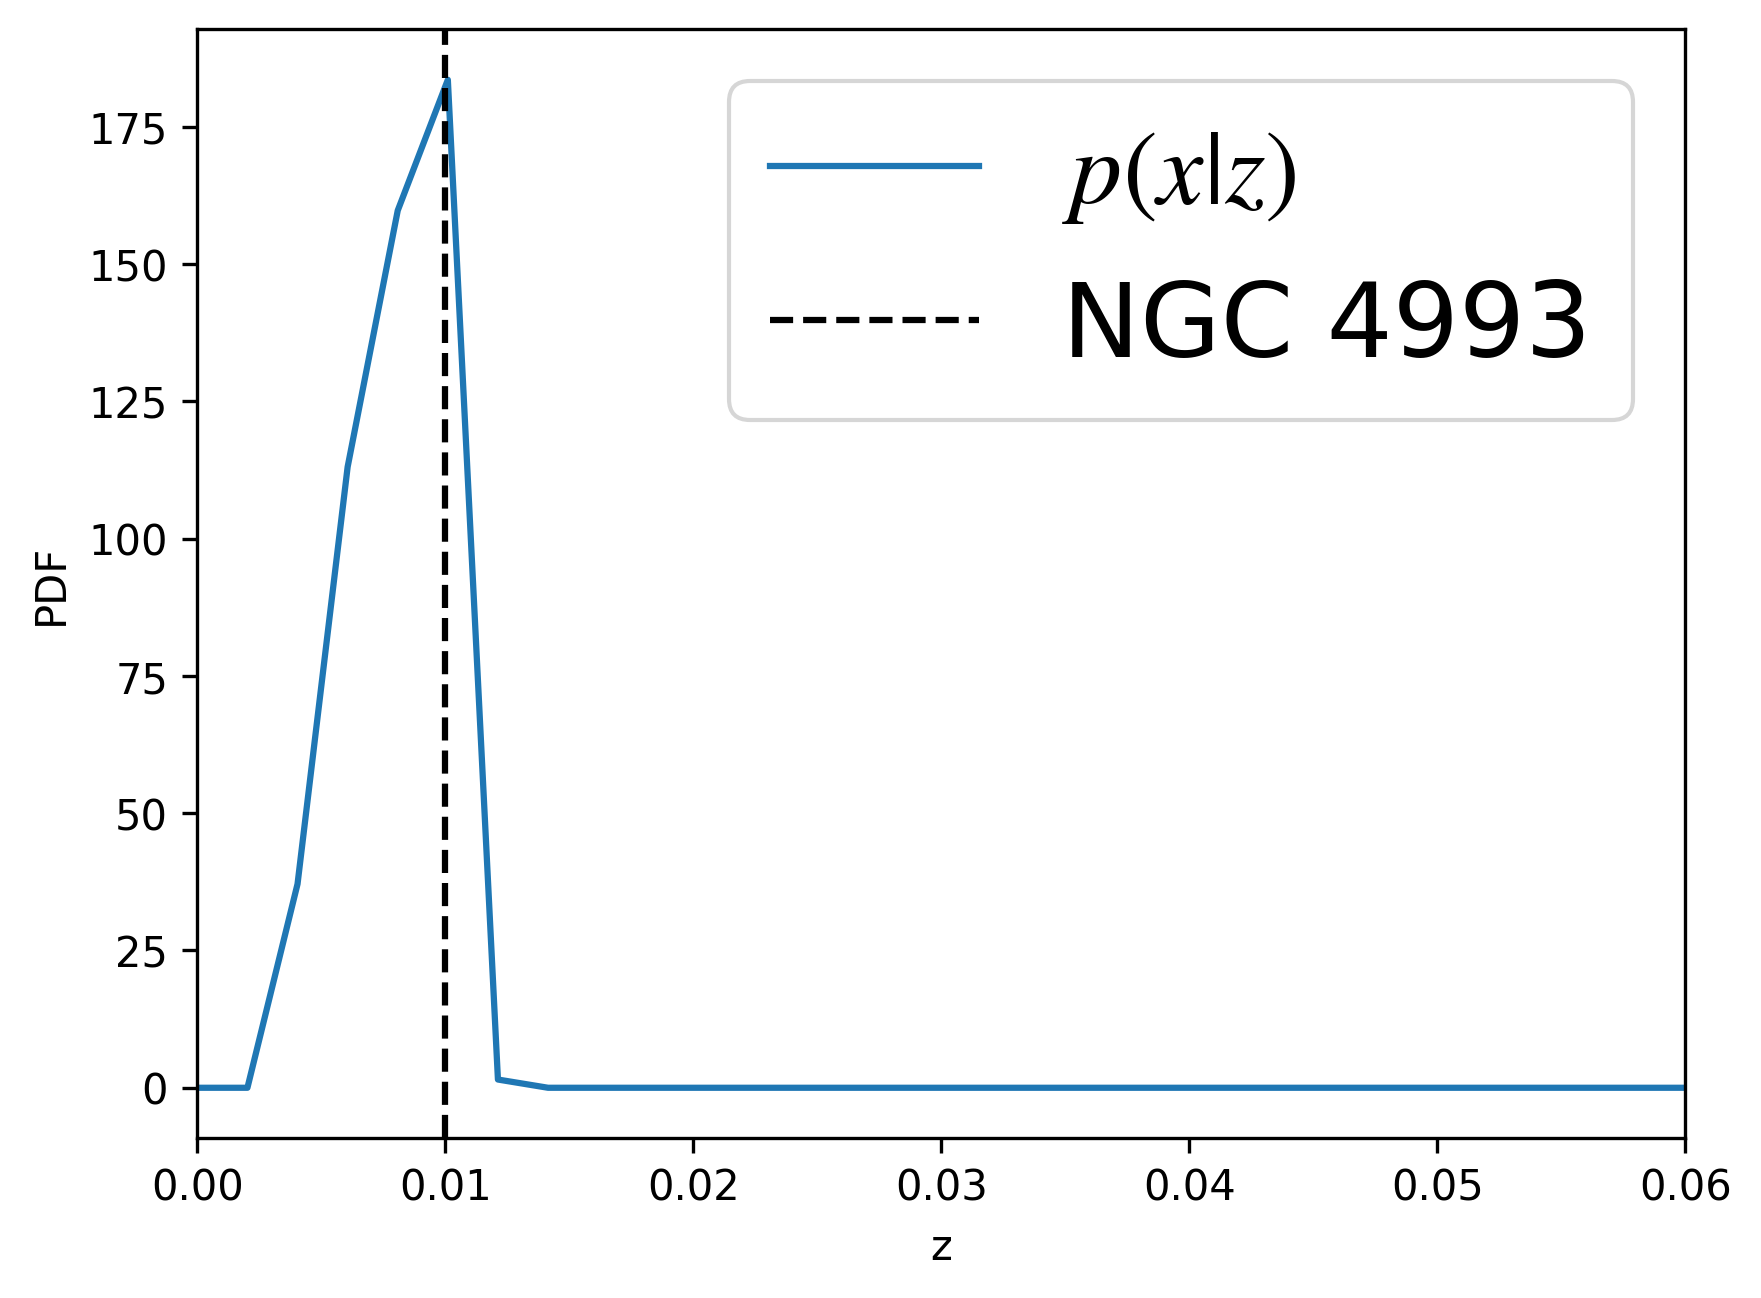

In [219]:
z_likelihood = GW170817.marginalized_redshift_reweight(70, 'BNS')[0]
print(GW170817.marginalized_redshift_reweight(70, 'BNS'))
norm = np.trapz(z_likelihood(z_array), z_array)
print(norm)
plt.plot(z_array, z_likelihood(z_array)/norm,label=r'$p(x|z)$')
plt.xlabel('z')
plt.ylabel('PDF')
plt.axvline(0.01,ls='--',c='k',label='NGC 4993')
plt.xlim(0.000, 0.060)
plt.legend(fontsize=25)

## Let's do the analysis now


In [87]:
import gwcosmo
from astropy.constants import c
from tqdm import tqdm

H0_array = np.linspace(20, 200, 200) # Define the H0 for the analysis

# Load posterior samples
samples = gwcosmo.likelihood.posterior_samples.posterior_samples('GW170817_GWTC-1.hdf5')
posterior = np.ones_like(H0_array)

# Load pdet
pdet = pickle.load(open(data_path+
                        'O2PSD_BNS_Nsamps20000_full_waveform_snr_12.0.p', 'rb'))

cval = c.to('km/s').value

#Create redshift samples from NGC4993
z_array = np.linspace(0, 0.1,1000)
z_NGC4993 = np.random.randn(500)*150+3017
z_NGC4993/=cval

# The redshift prior
p_z = redshift_prior()


for i, H0 in tqdm(enumerate(H0_array)):
    
    # Calculate selection effect
    beta = np.trapz(pdet.pD_zH0_eval(z_array,H0) * p_z.p_z(z_array), z_array)
    
    # Calculate the redshift kernel for the GW part
    z_likelihood, ww = samples.marginalized_redshift_reweight(H0,'BNS')
    
    # Marginalize over redshift
    posterior[i] = np.sum(z_likelihood(z_NGC4993)*p_z.p_z(z_NGC4993))*ww/beta
    
# Normalize
posterior/=np.trapz(posterior, H0_array)

# print(beta)
# print(z_NGC4993)
# mean
mean = np.trapz(posterior * H0_array, H0_array)
print(mean)


200it [01:24,  2.37it/s]

6.887875132654322e-05
[0.0098098  0.01039332 0.01036283 0.0097453  0.00972479 0.01083258
 0.00921137 0.01046162 0.01014384 0.01001754 0.01018521 0.01081012
 0.01037651 0.01063565 0.01094832 0.01031029 0.01072294 0.00971205
 0.0097193  0.00950575 0.01007512 0.009628   0.01096718 0.01002252
 0.00981048 0.01017024 0.00992514 0.0108772  0.00970705 0.01006535
 0.00980524 0.00987899 0.00977135 0.01009261 0.00935331 0.00945396
 0.00984817 0.00996114 0.00954107 0.00995933 0.00966616 0.01025909
 0.01013008 0.00972901 0.0102061  0.00994584 0.01024989 0.00967249
 0.0104679  0.00993994 0.00903823 0.01050827 0.01064163 0.00999761
 0.00922432 0.01030676 0.0092352  0.00929819 0.00975577 0.00978178
 0.00968205 0.00948643 0.00983862 0.01023163 0.00986084 0.01032557
 0.00978723 0.01060652 0.00945309 0.01016907 0.01081081 0.0101337
 0.01033713 0.00942219 0.00994942 0.01134602 0.01001204 0.00944895
 0.00978017 0.00981943 0.01075996 0.01037364 0.01043951 0.01034576
 0.00966964 0.00949764 0.00981542 0.01048

Text(0, 0.5, 'PDF')

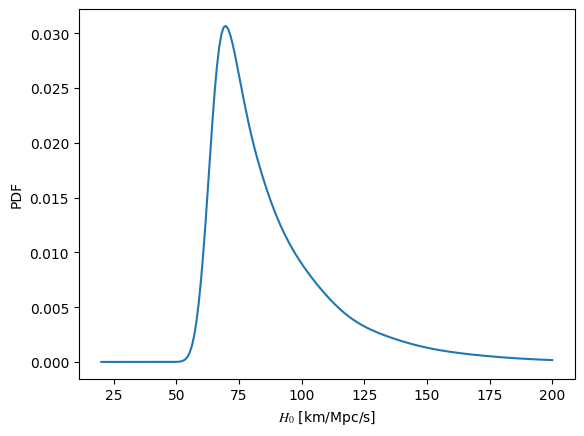

In [85]:
plt.plot(H0_array, posterior)
plt.xlabel(r'$H_0$ [km/Mpc/s]')
plt.ylabel('PDF')

In [187]:
import pandas as pd
import scipy.integrate as integrate
from scipy.interpolate import CubicSpline

posterior1 = pd.read_csv('posterior.csv', header=None)
h_array = np.array(posterior1)[:, 0]
pdf_array = np.array(posterior1)[:, 1]
# print(H0_array)
print(len(h_array))
print(len(pdf_array))
# print(h_array)

h = np.delete(h_array, 28)
p = np.delete(pdf_array, 28)
Abbott = CubicSpline(h, p)
hAbbott = CubicSpline(h, p * h)
integration0 = integrate.quad(hAbbott, h[0], h[-1])[0]
sigma = 
# integration1 = integrate.quad(Abbott, 77.1 - sigma, 77.1 - sigma)[0]

print(integration0, '+')
print(integration1, '+')
# integration1 = integrate.quad(ours, 69.7 - 50, 69.7)[0]

# print(integration1, '-')
# plt.plot(H0_array, ours(H0_array))
# plt.show()
# print(len(h_array))
# print(len(pdf_array))
# print(np.argmax(pdf_array))
# mean_1 = np.trapz(pdf_array * h_array, h_array)
# print(mean_1)
# print(np.argmax(posterior))
# print(H0_array[np.argmax(posterior)])

# print(H0_array[92])
# sigma = np.trapz(posterior[51:65], H0_array[51:65])
# # print(H0_array[64])
# print(sigma, 'sigmaa')

179
179
77.08094483283313 +


In [192]:
# finding the minimal 68% credible interval
import numpy as np

import numpy as np

def minimal_credible_interval(x, pdf, credibility=0.68):
    """
    Calculate the minimal credible interval for a non-symmetric distribution.
    
    Parameters:
        x (array-like): The array of values of the random variable.
        pdf (array-like): The corresponding probability density function values.
        credibility (float): The desired credibility level, default is 0.68 (68%).
        
    Returns:
        dict: A dictionary containing the start, end, and length of the interval.
    """
    # Normalize the PDF to ensure it integrates to 1
    dx = np.diff(x, prepend=x[0])
    pdf = pdf / np.sum(pdf * dx)
    
    # Calculate the cumulative density function (CDF)
    cdf = np.cumsum(pdf * dx)
    
    # Identify the total probability mass to enclose
    target_mass = credibility
    
    # Initialize variables to track the shortest interval
    min_length = float('inf')
    start, end = None, None
    
    # Use a sliding window to find the shortest interval
    for i in range(len(cdf)):
        for j in range(i + 1, len(cdf)):
            prob_mass = cdf[j] - cdf[i]
            if prob_mass >= target_mass:
                interval_length = x[j] - x[i]
                if interval_length < min_length:
                    min_length = interval_length
                    start, end = x[i], x[j]
                break  # Stop once the first valid interval is found for this starting point
    
    return {
        "start": start,
        "end": end,
        "length": min_length
    }


print(minimal_credible_interval(x=h_array, pdf=pdf_array, credibility=0.68))
print(minimal_credible_interval(H0_array, posterior, credibility=0.68))
print(69.7-59.798994974874375, 92.36180904522614-69.7)


{'start': 62.088197157127105, 'end': 82.0170170994642, 'length': 19.928819942337093}
{'start': 59.798994974874375, 'end': 92.36180904522614, 'length': 32.56281407035176}
9.901005025125627 22.661809045226136


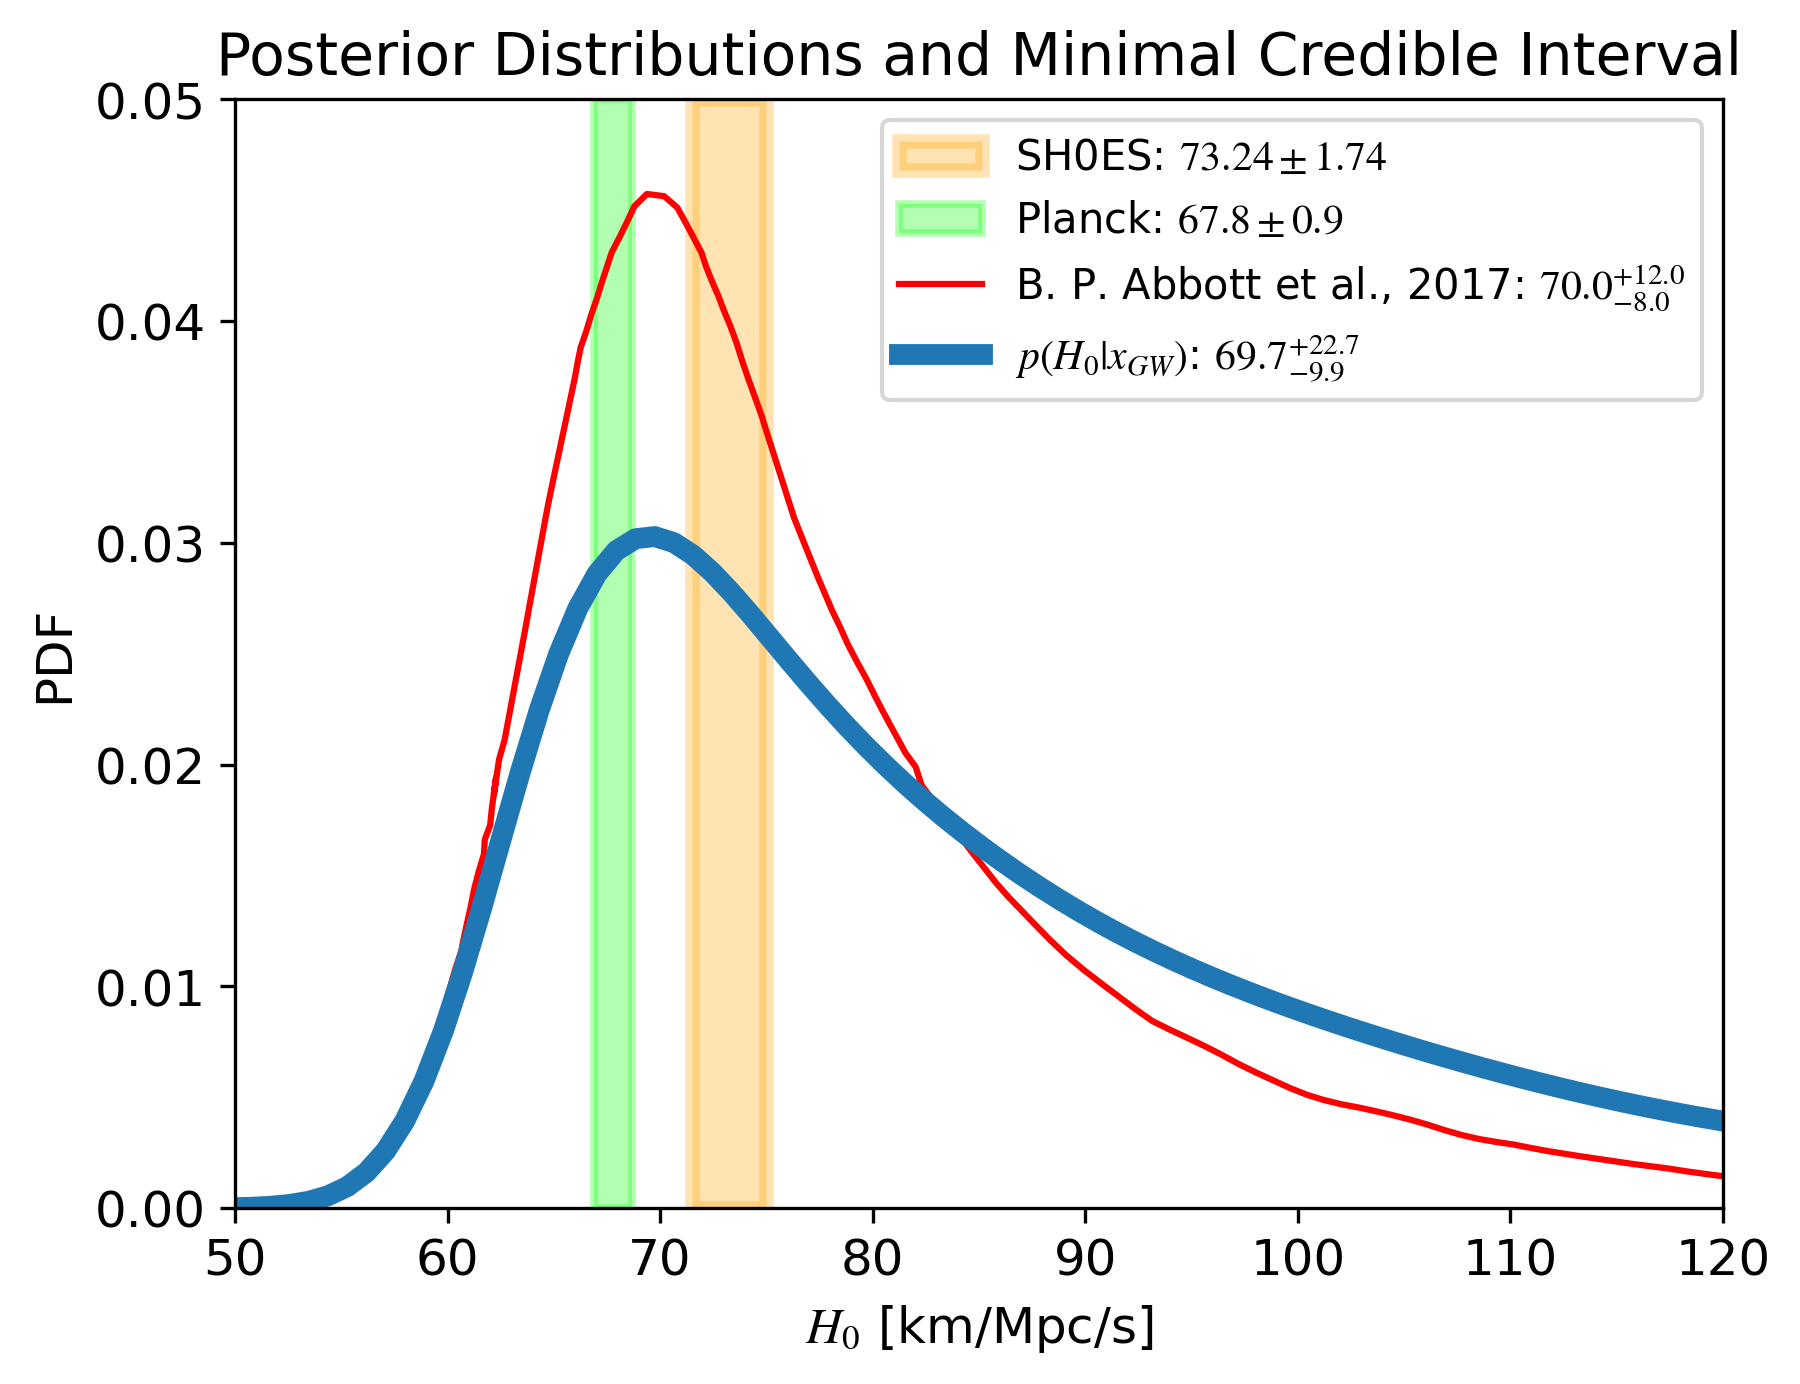

In [218]:
plt.rcParams['figure.dpi'] = 300
h_array = np.array(posterior1)[:, 0]
pdf_array = np.array(posterior1)[:, 1]
SH0ES =  73.24 # 73.24±1.74
Planck = 67.8 # 67.8±0.9
plt.title('Posterior Distributions and Minimal Credible Interval', fontsize=14)
# plt.figure(figsize=(13, 10))
plt.axvspan(SH0ES-1.74, SH0ES+1.74, color = 'orange', linewidth=1.74 * 2, alpha=0.3, label=rf'SH0ES: $73.24\pm1.74$', edgecolor='none')
plt.axvspan(Planck-0.9, Planck+0.9,color = 'lime', linewidth=0.9 * 2, alpha=0.3, label=rf'Planck: $67.8\pm0.9$', edgecolor='none')
plt.plot(h_array, pdf_array, color='r', label=r'B. P. Abbott et al., 2017: $70.0^{+12.0}_{-8.0}$')
plt.plot(H0_array, posterior, label=r'$p(H_0|x_{GW})$: $69.7^{+22.7}_{-9.9}$', linewidth=5)
plt.xlim(50, 120)
plt.ylim(0.0, 0.05)
plt.xlabel(r'$H_0$ [km/Mpc/s]', fontsize=12)
plt.ylabel(r'PDF', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize = 10)

# plt.show()


## Bonus GW170729

GW170729 was the furthest and heaviest event that we detected during O2. For this event we do not have an EM counterpart and also galaxy catalogue are not very complete at those redshift.

However, this event can be used to probe cosmology assuming certain types of mass priros at the source frame.


In [17]:
#!wget https://dcc.ligo.org/public/0157/P1800370/005/GW170729_GWTC-1.hdf5

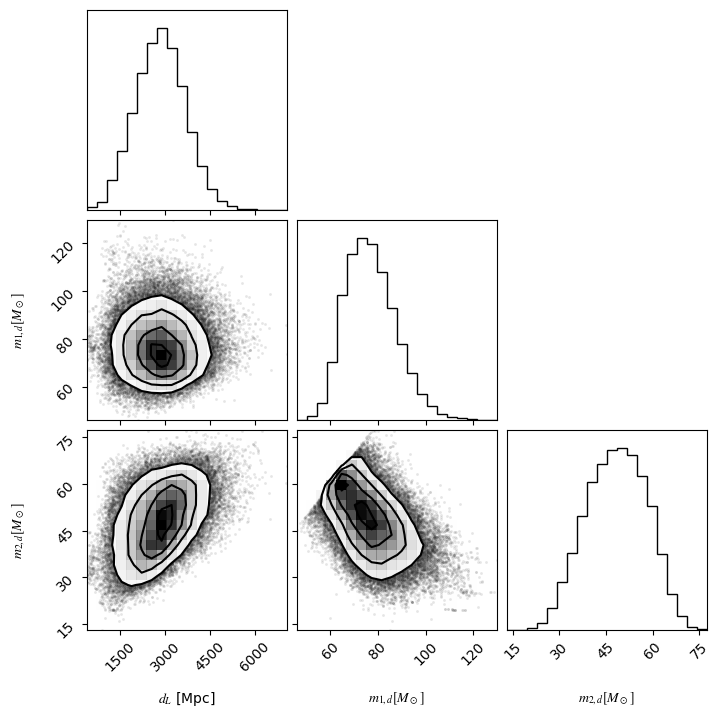

In [76]:
from gwcosmo.likelihood.posterior_samples import posterior_samples
import corner.corner

GW170729 = posterior_samples('GW170729_GWTC-1.hdf5')

# Plots in detector frame
to_plot = np.column_stack([GW170729.distance,GW170729.mass_1,GW170729.mass_2])
_ = corner.corner(to_plot,labels=[r'$d_L$ [Mpc]', r'$m_{1,d} [M_\odot]$ ',r'$m_{2,d} [M_\odot]$ '])

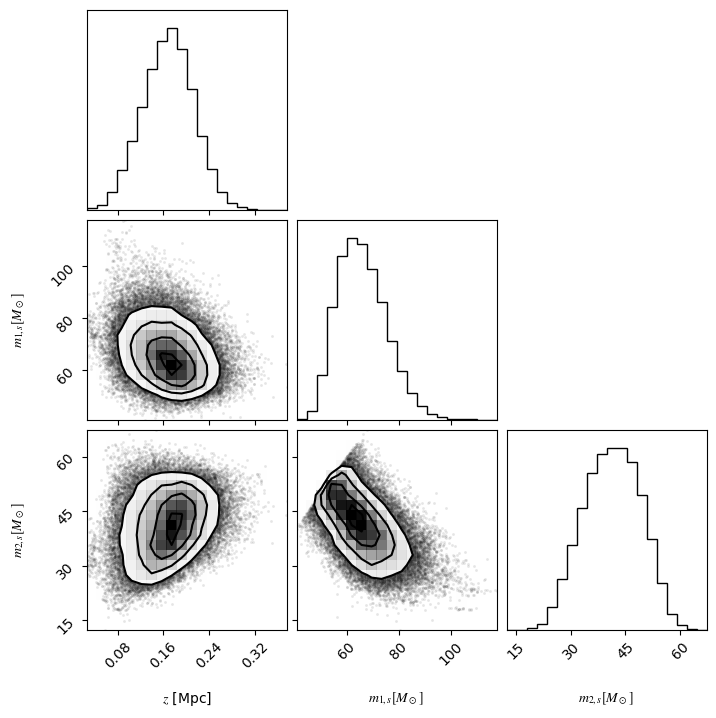

In [77]:
# Plots in source frame, lowering H0 shift the source masses at higher values
redshift, mass_1_source, mass_2_source = GW170729.compute_source_frame_samples(20)
to_plot = np.column_stack([redshift, mass_1_source, mass_2_source])
_ = corner.corner(to_plot,labels=[r'$z$ [Mpc]', r'$m_{1,s} [M_\odot]$ ', r'$m_{2,s} [M_\odot]$ '])


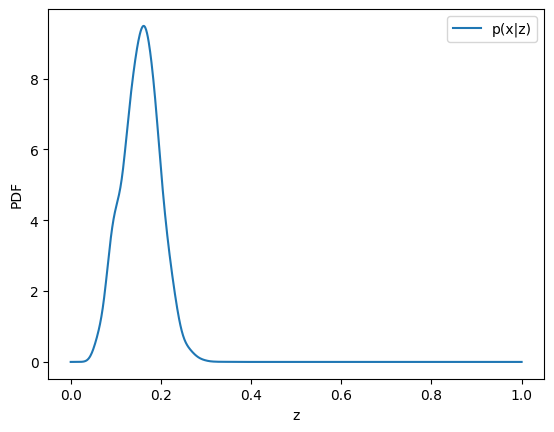

In [78]:
z_array = np.linspace(0,1,1000)

z_likelihood = GW170729.marginalized_redshift_reweight(20,'BBH-powerlaw',mmin=5,mmax=50)[0]
plt.plot(z_array,z_likelihood(z_array),label=r'p(x|z)')
plt.xlabel('z')
plt.ylabel('PDF')
plt.legend()

In [79]:
import gwcosmo
from astropy.constants import c
from tqdm import tqdm

H0_array = np.linspace(20,200,100) # Define the H0 for the analysis

# Load posterior samples
samples = gwcosmo.likelihood.posterior_samples.posterior_samples('GW170729_GWTC-1.hdf5')
posterior = np.ones_like(H0_array)

# Load pdet
pdet = pickle.load(open(data_path+
                        'O2PSD_BNS_Nsamps20000_full_waveform_snr_12.0.p', 'rb'))

cval = c.to('km/s').value

#Create redshift samples from NGC4993
z_array = np.linspace(0,2,5000)

# The redshift prior
p_z = redshift_prior()

for i,H0 in tqdm(enumerate(H0_array)):
    
    # Calculate selection effect
    beta =np.trapz(pdet.pD_zH0_eval(z_array,H0)*p_z.p_z(z_array),z_array)
    
    # Calculate the redshift kernel for the GW part
    z_likelihood, ww = samples.marginalized_redshift_reweight(H0,'BBH-powerlaw',mmin=5,mmax=50)
    
    samples_GW = z_likelihood.resample(1000)
    # Marginalize over redshift
    posterior[i]=np.sum(p_z.p_z(samples_GW))*ww/beta
    
# Normalize
posterior/=np.trapz(posterior,H0_array)
    



100it [00:36,  2.75it/s]


Text(0, 0.5, 'PDF')

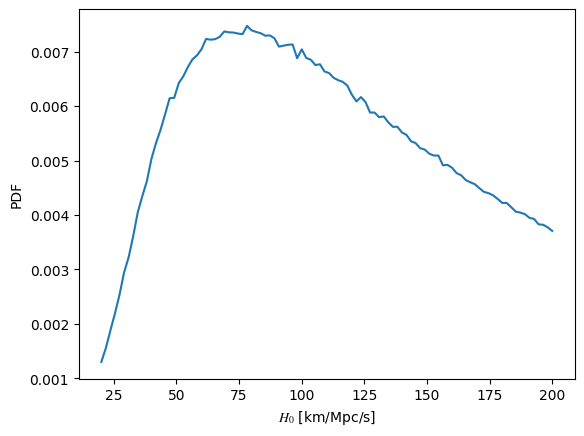

In [80]:
plt.plot(H0_array,posterior)
plt.xlabel(r'$H_0$ [km/Mpc/s]')
plt.ylabel('PDF')